In [1]:
!pip install flax

In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/weightsFlax")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax 
import flax.nn as nn

In [4]:
def P_local_matvec(k, K, w1, w2, x):
    x1 = x.reshape((2**k, -1))
    tmp = jnp.zeros(x1.shape)
    tmp = jax.ops.index_update(tmp, jax.ops.index[:-1, :], x1[1:, :])
    res = (x1@w1) + (tmp@w2)
    return res.flatten()


def P_local_matvec_t(k, K, w1, w2, x):
    x1 = x.reshape((2**k, -1))     #Can we make a 2D version
    tmp = jnp.zeros(x1.shape)
    tmp = jax.ops.index_update(tmp, jax.ops.index[1:, :], x1[:-1, :])
    res = x1@w1.T + (tmp@w2.T)

    return res.flatten()


class Projector_direct(nn.Module):
    def apply(self, x, k, K):
        s = (K-k)
        sp = (2**s, 1)
        w1 = self.param('w1', sp, nn.initializers.lecun_normal())
        w2 = self.param('w2', sp, nn.initializers.lecun_normal())
        x1 = x.reshape((2**k, -1))
        y = P_local_matvec(k, K, w1, w2, x1)
        z = P_local_matvec_t(k, K, w1, w2, y)
        z = z.reshape(x.shape)
        return z


In [5]:
def get_init_params(k, K):
    s = (K-k)
    xi = jnp.ones(2**s)
    eta = (jnp.arange(2**s) + 1)*1.0*(2**(-s))
    xi = jnp.reshape(xi, (-1, 1))
    eta = jnp.reshape(eta, (-1, 1))
    w1 = eta
    w2 = xi - eta
    w1 = w1*(2**(-s/2))
    w2 = w2*(2**(-s/2))
    return w1, w2

In [6]:
class BPX(nn.Module):
    def apply(self, x, K):
        y = jnp.zeros(x.shape)
        for k in range(K+1):
            scale = self.param('scale_{0:d}'.format(k), (1, ), nn.initializers.ones)
            y = y + 0.5*(scale + abs(scale))*Projector_direct(x, k, K)
        return y


def init_BPX(K, model):
    params = {}
    for k in range(K+1):
        name = 'Projector_direct_{0:d}'.format(k)
        scale_name = 'scale_{0:d}'.format(k)
        w1, w2 = get_init_params(k, K)
        loc_params = {'w1': w1, 'w2': w2}
        params[name] = loc_params
        params[scale_name] = jnp.reshape(2**(-k), (1, ))*0.05
        #params[scale_name] = jnp.reshape(2**(-k), (1, ))*1e-2

    return model.replace(params=params)

In [7]:
# def loss(dpx_model, mat, x):
#     sz = x.shape
#     y = x
#     dpx_model_batch = jax.vmap(dpx_model, 1, 1) 
#     z = y
#     for i in range(3):
#         z = y.reshape(y.shape) 
#         By = dpx_model_batch(z) 
#         By = jnp.reshape(By, y.shape)
#         By = mat@By 
#         By = dpx_model_batch(By) 
        
#         y = y - By 
#     return jnp.mean(jnp.einsum('ib, ib->b', y, y))

In [7]:
def loss(dpx_model, mat, x):
    sz = x.shape
    y = x
    dpx_model_batch = jax.vmap(dpx_model, 1, 1) 
    z = y
    k = 20
    for i in range(k):
        z = y.reshape(y.shape) 
        By = dpx_model_batch(z) 
        By = jnp.reshape(By, y.shape)
        By = mat@By 
        By = dpx_model_batch(By) 
        
        y = y - By 
    answer = jnp.mean(jnp.einsum('ib, ib->b', y, y))
    return jnp.power(answer, 1/(2*k))

In [8]:
rng = jax.random.PRNGKey(2010)
rng, key = jax.random.split(rng)

K = 5
B_cur = BPX.partial(K=K)
n = 2**K
x0 = jnp.ones(n)
_, init_params = B_cur.init(key, x0)
init_model = nn.Model(B_cur, init_params)
true_BPX = init_BPX(K, init_model)

# K = 5
# n = 2**K 
z = jnp.diag(jnp.ones(n-1), -1)
e = jnp.eye(n)
lp = 2*e - z - z.T
lp = lp*(n+1)**2

c = 1e2 # convection coefficient

mat = lp
model = true_BPX

In [9]:
x0 = jnp.ones(n)
v_r =  jax.random.uniform(key, x0.shape)

In [10]:
vr

NameError: ignored

In [10]:
def power_method(dpx_model, mat, x = v_r):
  x1 = x
  z = jnp.eye(mat.shape[0])
  dpx = jax.vmap(dpx_model, 1, 1) 
  prec = dpx(z)
  for i in range(500):
    matrix = z - prec @ mat @ prec
    vec = matrix @ x
    vec = vec / jnp.linalg.norm(x)
    eigen = vec @ x
    x = vec
    # if (jnp.linalg.norm(vec - eigen*x1)<=0.000001):
    #       # print('in if')
    #     return eigen

  return eigen

In [11]:
def true_eig(dpx_model, mat):
  z = jnp.eye(mat.shape[0])
  dpx = jax.vmap(dpx_model, 1, 1) 
  prec = dpx(z)
  matrix = z - prec @ mat @ prec
  w, _ = np.linalg.eig(z - prec@mat@prec)
  return  max(w)

In [13]:
array = jnp.array([ 0,   1,   8,  27,  64, 125])
jnp.power(array, 1/3)

DeviceArray([0., 1., 2., 3., 4., 5.], dtype=float32)

In [13]:
z = jnp.eye(mat.shape[0])
dpx = jax.vmap(model, 1, 1) 
prec = dpx(z)
matrix = z - prec @ mat @ prec
np.mean(np.diag(matrix))

0.97911835

In [30]:
jnp.mean(jnp.einsum('ib, ib->b', matrix, matrix))

DeviceArray(0.96039873, dtype=float32)

In [15]:
power_method(model, mat)

DeviceArray(0.9879836, dtype=float32)

In [16]:
true_eig(model, mat)

0.9946746

In [33]:
z = jnp.eye(mat.shape[0])
dpx = jax.vmap(model, 1, 1) 
prec = dpx(z)
prec.shape

(32, 32)

In [34]:
w, _ = np.linalg.eig(z - prec@mat@prec)

In [35]:
max(w)

0.9946746

In [12]:
n = 2**K
batch_size = 512
x_batch = jax.random.normal(key, (n, batch_size))
x_batch_eye = jnp.eye(n)
x_batch = x_batch/jnp.linalg.norm(x_batch, axis=0)[None, :]

In [13]:
@jax.jit
def update(opt, x):
    # eig = jnp.mean(jnp.mean(power_method_update(opt.target, mat, x)))
    l1, grad1 = jax.value_and_grad(loss)(opt.target, mat, x)
    return   l1, opt.apply_gradient(grad1)

In [14]:
opt = flax.optim.Adam(1e-5).create(model)

In [15]:
import matplotlib.pyplot as plt
loss_array = []
eigen_array = []
true_eigs = []

In [16]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt


def plot(loss_history, eig_history, eigs_true, iter_number, clear_output=True):
    if clear_output:
        display.clear_output(wait=True)
    #eigs_true, ax.plot(eigs_true, label = 'true eigs')
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.plot(loss_history, label = 'loss_history')
    ax.plot(eigs_true, label = 'true eigs')
    if eig_history:
      ax.plot(eig_history, label = 'eig_history')
    ax.set_title('loss and eig decay')
    ax.set_xlabel('# iteration processed')
    # ax.set_ylabel('loss value')
    ax.legend()

    plt.show()  

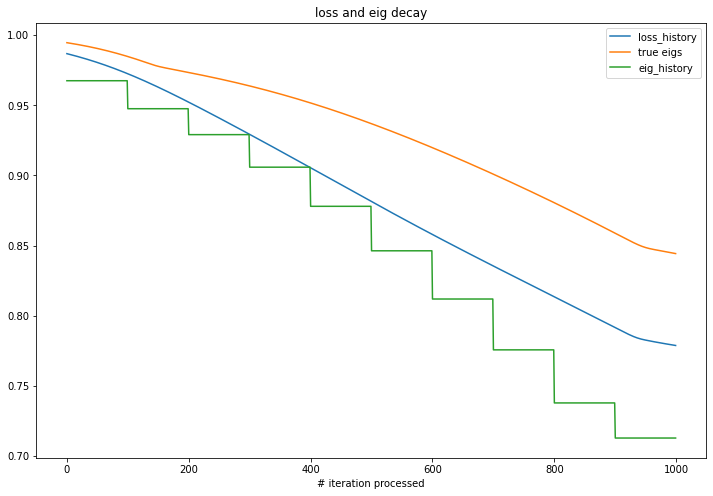

100%|██████████| 1000/1000 [08:36<00:00,  1.94it/s]


In [17]:
from tqdm import tqdm

for i in tqdm(range(1000)):
    loss_val, opt = update(opt, x_batch)

    true_eigs.append(true_eig(opt.target, mat))
    if (i+1)%100 == 0:
      eig_val = power_method(opt.target, mat)
      eigen_array.extend(100*[eig_val])
    loss_array.append(loss_val)
    # eigen_array.append(eig_val)
    plot(loss_array, eigen_array, true_eigs,  i)

In [19]:
a = flax.serialization.msgpack_serialize(opt.target.params)
f = open('/content/drive/My Drive/weightsFlax/rigtht_k5i20.txt', 'wb')
f.write(a)

961

In [99]:
  power_method(opt.target, mat)

DeviceArray(0.8486502, dtype=float32)

In [101]:
z = jnp.eye(mat.shape[0])
dpx = jax.vmap(opt.target, 1, 1) 
prec = dpx(z)

w, _ = np.linalg.eig(z - prec@mat@prec)
max(w)

0.92122215

In [100]:
z = jnp.eye(mat.shape[0])
dpx = jax.vmap(model, 1, 1) 
prec = dpx(z)

w, _ = np.linalg.eig(z - prec@mat@prec)
max(w)

0.9946746